<h1 style="text-align: center;"> Учебно-исследовательская работа по теме <br>"Разработка решения для сегментации изображений <br> на экран и окружающую область"</h1>

<h2><b>Подготовка инструментов выполнения</b></h2>

 <h3><b>1. Установка зависимостей</b></h3>

In [64]:
%%capture
!pip install tensorflow==2.10.0 numpy==1.24.2 pandas==2.2.1 matplotlib==3.8.0 Pillow==10.1.0 albumentations==2.0.5 pycocotools==2.0.8 roboflow==1.1.55 segmentation-models==1.0.1

<h3><b>2. Импорт библиотек</b></h3>

In [ ]:
import tensorflow as tf
import os
import json
import numpy as np
import pandas as pd
import albumentations as A
import segmentation_models as sm
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from roboflow import Roboflow
from PIL import Image

In [4]:
# Проверка GPU
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Найдено {len(gpus)} GPU:")
    for gpu in gpus:
        print(f" - {gpu}")
        tf.config.experimental.set_memory_growth(gpu, True)  # Динамическое выделение памяти
else:
    raise RuntimeError("GPU не найдено! Проверьте установку CUDA 11.2 и cuDNN 8.1.")

TensorFlow version: 2.10.0
Найдено 1 GPU:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


<h2><b>Обработка датасета</b></h2>
В этом разделе мы подготовим датасет для обучения модели в формате <b>COCO</b> для <b>TensorFlow</b>.
<h3><b>1. Загрузка данных</b></h3>

Для поиска датасета воспользуемся ресурсом датасетов "<a href="https://universe.roboflow.com">Roboflow</a>".


Теперь используем Roboflow для загрузки нужного датасета в формате COCO (в директории должна создаться папка "Screen-segmentation-3"):

In [ ]:
rf = Roboflow(api_key="to3YrOBj0FlHoBjF9Vwn")
project = rf.workspace("uit-kbay3").project("screen-segmentation")
version = project.version(3)
dataset = version.download("coco-segmentation")
                


loading Roboflow workspace...
loading Roboflow project...


В папке датасет уже разделён на выборки train и test. Как правило, в машинном обучении выборка разбивается на два набора:
- **Train (обучающая выборка)** – используется для обновления весов модели.
- **Test (тестовая выборка)** – используется только после обучения на данных, которые модель не видела - на основе результатов строит оценка модели.


Такое разбиение необходимо, чтобы убедиться, что модель не просто запомнила тренировочные данные, а действительно способна правильно сегментировать новые изображения.


<h3><b>2. Определение путей и гиперпараметров</b></h3>

Гиперпараметры - это параметры, которые задаются перед началом обучения модели и оказывают значительное влияние на процесс обучения:
- `IMG_SIZE` - размер входных изображений. Чем больше размер, тем больше информации сохраняется, но выше требования к памяти.
- `BATCH_SIZE` - количество изображений, подаваемых в модель за одну итерацию. Оптимально выбирать в зависимости от доступной памяти GPU.
- `EPOCHS` - количество эпох (проходов через весь датасет). Большее количество эпох может улучшить результаты, но увеличивает время тренировки.
- `BACKBONE` - предобученная модель-энкодер на основе которой будет строиться модель U-Net.
- `FREEZE_ENCODER` - заморозка слоев энкодера. если данных недостаточно, мы можем заморозить веса энкодера, чтобы использовать его как фиксированное представление признаков, что помогает избежать переобучения модели
- `LEARNING_RATE` - 

Запишем гиперпарметры в переменные:

In [13]:
IMG_SIZE = 512  # Размер входных изображений
BATCH_SIZE = 4  # Размер батча
EPOCHS = 20  # Количество эпох обучения (чем больше, тем лучше, но дольше)
BACKBONE = "resnet50"  # Предобученный энкодер (еще "resnet50", "mobilenetv2", "vgg16")
FREEZE_ENCODER = True  # Заморозить энкодер, если данных мало (< 10000 изображений)
LEARNING_RATE = 1e-3
NUM_CLASSES = 1  # Количество классов (фон + объект)


Перед началом работы с датасетом заведём отдельную переменную под хранение путей к файлам датасета. Для этого напишем следующее:

In [14]:
# Пути к данным
DATASET_PATH = "./Screen-segmentation-3"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test/"
TRAIN_JSON = TRAIN_PATH + "_annotations.coco.json" 
TEST_JSON = TEST_PATH + "_annotations.coco.json"   

# Проверка существования путей к данным
print("Проверка путей:")
print("Train JSON path:", os.path.exists(TRAIN_JSON))
print("Test JSON path:", os.path.exists(TEST_JSON))
print("Train folder path:", os.path.exists(TRAIN_PATH))
print("Test folder path:", os.path.exists(TEST_PATH))

Проверка путей:
Train JSON path: True
Test JSON path: True
Train folder path: True
Test folder path: True


<h3><b>3. Процесс аугментации</b></h3>

In [15]:
# Определяем аугментации с помощью albumentations
augment = A.Compose([
    A.HorizontalFlip(p=0.25),  # Горизонтальное отражение с вероятностью 25%
    A.RandomBrightnessContrast(p=0.3),  # Изменение яркости и контрастности с вероятностью 30%
    A.VerticalFlip(p=0.25)  # Вертикальное отражение с вероятностью 25%
])

# Функция аугментации
def augment_fn(image, mask):
    # Преобразуем тензоры в NumPy и приводим к формату albumentations
    image_np = (image.numpy() * 255).astype(np.float32)  # Из [0, 1] в [0, 255]
    mask_np = mask.numpy()[..., 0] 
    
    # Применяем аугментацию
    augmented = augment(image=image_np, mask=mask_np)
    
    # Возвращаем обратно в тензоры
    image_aug = tf.convert_to_tensor(augmented['image'], dtype=tf.float32) / 255.0
    mask_aug = tf.convert_to_tensor(augmented['mask'], dtype=tf.float32)[..., tf.newaxis]  # Добавляем канал здесь
    
    return image_aug, mask_aug

<h3><b>4. Функция загрузки и обработки данных COCO</b></h3>

Далее мы приступаем к подготовке данных для обучения модели. Для этого используем формат COCO, который является эффективным форматом хранения данных для TensorFlow. 



In [17]:
# Функция для загрузки и обработки данных COCO
def load_and_process_coco(json_path, img_dir):
    # Инициализируем COCO-объект
    coco = COCO(json_path)
    img_ids = coco.getImgIds()
    
    print(f"Найдено {len(img_ids)} изображений в {json_path}")
    
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        
        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Получаем аннотации
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        
        # Создаём пустую маску
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        
        # Заполняем маску
        for ann in anns:
            if 'segmentation' in ann:
                mask |= coco.annToMask(ann)  # Объединяем маски всех объектов
        
        # Приводим к нужному размеру
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = tf.image.resize(mask[..., np.newaxis], (IMG_SIZE, IMG_SIZE), method='nearest')
        
        # Применяем аугментацию через tf.py_function
        image, mask = tf.py_function(
            func=augment_fn,
            inp=[image, mask],
            Tout=[tf.float32, tf.float32]
        )
        
        # Устанавливаем форму после аугментации
        image.set_shape([IMG_SIZE, IMG_SIZE, 3])
        mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
        
        yield image, mask
        
        load_and_process_coco

        # Создаём датасеты
train_dataset = tf.data.Dataset.from_generator(
    lambda: load_and_process_coco(TRAIN_JSON, TRAIN_PATH),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)
    )
).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: load_and_process_coco(TEST_JSON, TEST_PATH),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Датасеты успешно созданы!")

Датасеты успешно созданы!


In [18]:
# Проверка размеров батчей
for image_batch, mask_batch in train_dataset.take(1):
    print("Размер батча изображений:", image_batch.shape)  # Ожидаем [8, 512, 512, 3]
    print("Размер батча масок:", mask_batch.shape)         # Ожидаем [8, 512, 512, 1]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Найдено 807 изображений в ./Screen-segmentation-3/train/_annotations.coco.json
Размер батча изображений: (4, 512, 512, 3)
Размер батча масок: (4, 512, 512, 1)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Найдено 807 изображений в ./Screen-segmentation-3/train/_annotations.coco.json


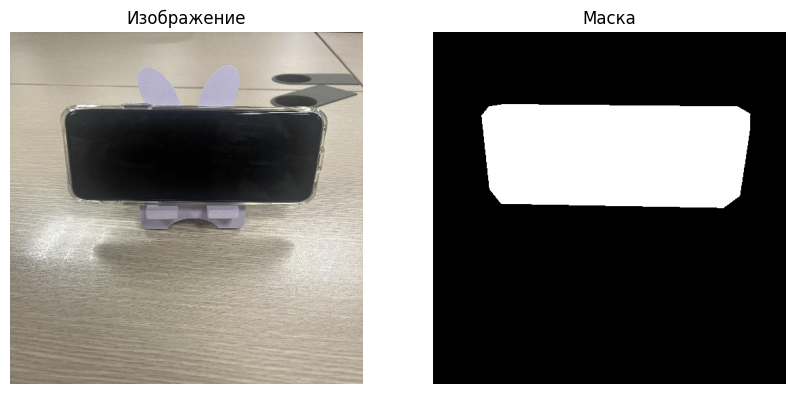

In [20]:
# Визуализация одного примера из датасета
def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))
    
    # Изображение
    plt.subplot(1, 2, 1)
    plt.title("Изображение")
    plt.imshow(image)
    plt.axis('off')
    
    # Маска
    plt.subplot(1, 2, 2)
    plt.title("Маска")
    plt.imshow(mask[..., 0], cmap='gray')
    plt.axis('off')
    
    plt.show()

# Берём один батч и визуализируем первый элемент
for image_batch, mask_batch in train_dataset.take(1):
    visualize_sample(image_batch[0], mask_batch[0])

<h3><b>5. Создание модели U-net</b></h3>

Теперь мы создадим саму модель U-Net, используя предобученный энкодер. Модель будет включать энкодер для извлечения признаков и декодер для восстановления сегментированного изображения.

In [ ]:
# Указываем backend перед импортом segmentation_models
os.environ['SM_FRAMEWORK'] = "tf.keras"

# Создаём модель U-Net с backbone ResNet50
model = sm.Unet(
    backbone_name=BACKBONE,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classes=NUM_CLASSES,
    activation='sigmoid',  # Для бинарной сегментации
    encoder_weights='imagenet',  # Предобученные веса
    encoder_freeze=FREEZE_ENCODER  # Замораживаем энкодер
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

<h3><b>6. Компиляция модели</b></h3>

После того, как модель построена, компилируем её с нужной функцией потерь и метриками для обучения.

Мы используем binary_crossentropy как функцию потерь, так как это задача бинарной сегментации (каждый пиксель принадлежит или не принадлежит объекту).

Метрика accuracy позволит отслеживать точность классификации.

In [ ]:
# Компилируем модель
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=sm.losses.BinaryFocalLoss(),  # Фокальная потеря для бинарной сегментации
    metrics=[sm.metrics.IOUScore(), 'accuracy']  # Метрики: IoU и точность
)

# Выводим информацию о модели
model.summary()

<h3><b>7. Обучение модели</b></h3>

Теперь тренируем модель на подготовленных данных.


In [22]:
# Указываем, что тренировка должна происходить на GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset,
        verbose=1
    )

# Сохранение модели
model.save("screen_segmentation_model_gpu.h5")

Epoch 1/20
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Найдено 807 изображений в ./Screen-segmentation-3/train/_annotations.coco.json
    202/Unknown - 93s 320ms/step - loss: 0.0456 - iou_score: 0.3117 - accuracy: 0.7743loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Найдено 84 изображений в ./Screen-segmentation-3/test/_annotations.coco.json
202/202 [==============================] - 98s 344ms/step - loss: 0.0456 - iou_score: 0.3117 - accuracy: 0.7743 - val_loss: 0.0569 - val_iou_score: 0.2198 - val_accuracy: 0.6643
Epoch 2/20
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Найдено 807 изображений в ./Screen-segmentation-3/train/_annotations.coco.json
202/202 [==============================] - ETA: 0s - loss: 0.0343 - iou_score: 0.3651 - accuracy: 0.8333loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Найдено 84 изображений в ./Screen-segmentat

<h3><b>8. Анализ результатов</b></h3>

Для оценки эффективности обучения строим графики функции потерь и точности.

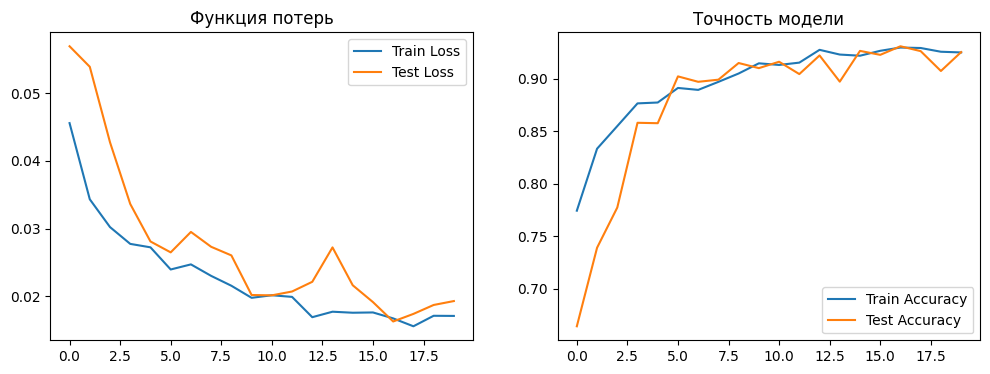

In [26]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.legend()
    plt.title('Функция потерь')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.legend()
    plt.title('Точность модели')
    
    plt.show()

plot_history(history)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def save_all_predicted_masks(model, train_dataset, test_dataset, train_output_dir="train_predicted_masks", test_output_dir="test_predicted_masks"):
    # Создаём папки для сохранения, если их нет
    os.makedirs(train_output_dir, exist_ok=True)
    os.makedirs(test_output_dir, exist_ok=True)
    
    # Функция для сохранения масок из датасета
    def save_masks(dataset, output_dir, prefix):
        total_saved = 0
        for i, (images, _) in enumerate(dataset):
            for j in range(images.shape[0]):  # Проходим по всем изображениям в батче
                image = images[j]
                
                # Делаем предсказание на GPU
                with tf.device('/GPU:0'):
                    pred_mask = model.predict(image[tf.newaxis, ...])[0]  # Добавляем batch dimension
                
                # Преобразуем предсказания в бинарную маску (порог 0.5)
                pred_mask = (pred_mask > 0.5).astype(np.float32)
                
                # Преобразуем тензор в numpy
                image = image.numpy()
                pred_mask = pred_mask[..., 0]  # Убираем канал
                
                # Накладываем красную маску
                overlay = image.copy()
                alpha = 0.4  # Прозрачность красной маски
                overlay[pred_mask == 1] = overlay[pred_mask == 1] * (1 - alpha) + np.array([1, 0, 0]) * alpha
                
                # Создаём фигуру для сохранения
                plt.figure(figsize=(5, 5))  # Размер изображения
                plt.imshow(overlay)
                plt.axis('off')
                
                # Сохраняем изображение
                output_path = os.path.join(output_dir, f"{prefix}_predicted_mask_{total_saved + 1}.png")
                plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
                plt.close()  # Закрываем фигуру
                
                total_saved += 1
        return total_saved
    
    # Сохранение для тренировочной выборки
    train_saved = save_masks(train_dataset, train_output_dir, "train")
    print(f"Сохранено {train_saved} изображений тренировочной выборки в папку '{train_output_dir}'")
    
    # Сохранение для тестовой выборки
    test_saved = save_masks(test_dataset, test_output_dir, "test")
    print(f"Сохранено {test_saved} изображений тестовой выборки в папку '{test_output_dir}'")

# Запуск сохранения для всех изображений из train_dataset и test_dataset
save_all_predicted_masks(model, train_dataset, test_dataset, train_output_dir="train_predicted_masks", test_output_dir="test_predicted_masks")

In [ ]:
import pandas as pd
import numpy as np

val_iou_scores = history.history["val_iou_score"]  # Точность (IoU) на валидации
val_accuracy = history.history["val_accuracy"]  # Accuracy на валидации
val_loss = history.history["val_loss"]
epoch_times = [93.32, 98.0, 87.0, 87.0, 88.0, 90.0, 86.0, 84.0, 85.0, 88.0, 87.0, 88.0, 87.0, 86.0, 85.0, 86.0, 85.0, 86.0, 85.0, 85.0]  # Время выполнения шага в секундах

# Расчет среднего и лучшего времени выполнения шага
mean_time_per_epoch = np.mean(epoch_times)

# Расчет общего времени обучения
total_training_time = np.sum(epoch_times)

# Расчет средней и лучшей точности (IoU)
mean_iou = np.mean(val_iou_scores)
best_iou = np.max(val_iou_scores)

# Расчет средней и лучшей accuracy на валидации
mean_val_accuracy = np.mean(val_accuracy)
best_val_accuracy = np.max(val_accuracy)

# Расчет лучшей функции потерь (минимальное значение)
best_val_loss = np.min(val_loss)



# Формирование таблицы
data = {
    "Параметр сети": ["Adam, ResNet50 + Full Augmentation"],
    "Средняя точность (IoU)": [mean_iou],
    "Лучшая точность (IoU)": [best_iou],
    "Средняя accuracy (test)": [mean_val_accuracy],
    "Лучшая accuracy (test)": [best_val_accuracy],
    "Лучшая функция потерь (test)": [best_val_loss],
    "Среднее время (с/эпоха)": [mean_time_per_epoch],
    "Общее время обучения (с)": [total_training_time]
}

df = pd.DataFrame(data)
display(df)

,Параметр сети,Средняя точность (IoU),Лучшая точность (IoU),Средняя accuracy (test),Лучшая accuracy (test),Лучшая функция потерь (test),Среднее время (с/эпоха),Общее время обучения (с)
0,"Adam, ResNet50 + Full Augmentation",0.481545,0.661112,0.879918,0.930869,0.016266,87.316,1746.32
